In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import os
sns.set(style="whitegrid")
sns.set_palette("colorblind")
fontsize = 20

#### ROUND SUMMARY

In [2]:
global_summary = pd.read_parquet('global_summary.parquet')
global_summary['exp_time'] = (global_summary['filtered_acc_distributed_time'] - global_summary['timestamps.start_experiment']).dt.total_seconds()
cols_key = ['clients_J', 'clients_kWh', 'server_J', 'server_kWh',
       'total_J', 'total_kWh', 'strategy', 'epoch',
       'filtered_acc_centralized_round', 'filtered_acc_centralized_time',
       'filtered_acc_centralized', 'filtered_acc_distributed_round',
       'filtered_acc_distributed_time', 'filtered_acc_distributed',
       'max_centralized_accuracy', 'max_centralized_accuracy_round',
       'max_distributed_accuracy', 'max_distributed_accuracy_round','exp_time']
global_summary_gb = global_summary[cols_key].groupby(['strategy','epoch']).mean()
#global_summary_gb

In [3]:
round_summary = pd.read_parquet('round_summary.parquet')

In [4]:
round_keys = ['client id','lr', 'fittime', 'server_round',
       'train_loss', 'train_acc', 'val_loss', 'val_acc',
       'avg_client_per_host_per_round', 'ClientID_host', 'round_energy_kWh',
       'round_energy_J', 'strategy', 'epoch',
       'round_energy_kWh_per_client']
round_summary = round_summary[round_keys]
round_summary_gb = round_summary[round_keys].groupby(['strategy','epoch','client id','server_round']).agg(['mean','count','std'])

In [5]:
# Filter round_sumary_gb to get the results corresponding to the average round to reach 75% from global_summary
# Get global summary round and time for each strategy and epoch
average_rounds = global_summary_gb['filtered_acc_distributed_round'].astype(int)
round_summary_gb = round_summary_gb.groupby(['strategy','epoch','client id','server_round']).filter(
    lambda x: x.index.get_level_values('server_round').max() <= average_rounds[x.index[0][:2]]
)

#### 1.ROUND TIME ANALYSIS

In [10]:
rs_keys = ['strategy','epoch','client id','server_round']
fittimes1 = round_summary_gb.xs('epoch_1', level='epoch')['fittime']
fittimes1 = fittimes1.reset_index()
fittimes5 = round_summary_gb.xs('epoch_5', level='epoch')['fittime']
fittimes5 = fittimes5.reset_index()

In [11]:
graph_path = "/Users/Slaton/Documents/grenoble-code/fl-flower/jetson-tl/graphs"
fittimes1_plot = os.path.join(graph_path,"fittimes1.pdf")
fittimes5_plot = os.path.join(graph_path,"fittimes5.pdf")

strategies_map = {
    'fedavg': 'FedAvg',
    'fedyogi': 'FedYogi',
    'fedadam': 'FedAdam',
    'fedadagrad': 'FedAdagrad',
    'fedavg_adam': 'FedAvg-Adam',
    'fedconstraints': 'FedAvg-SFW',
}

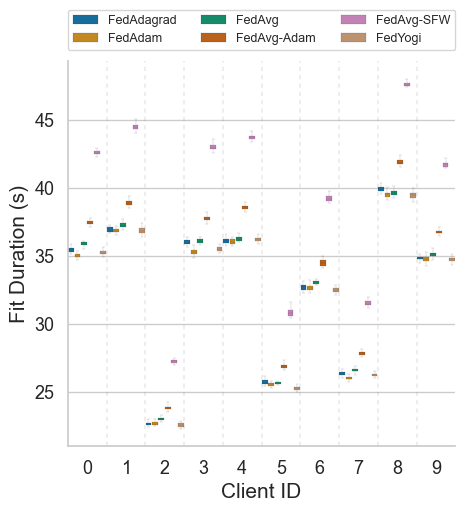

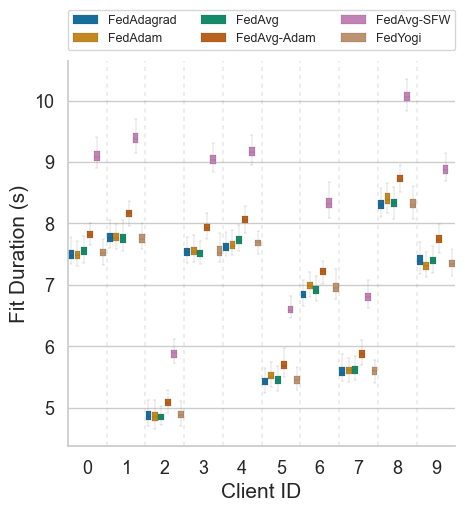

In [12]:
def plot_boxplot(df, save_path, strategies_map, fontsize=fontsize):
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    sns.boxplot(x='client id', y='mean', data=df, showfliers=False,hue='strategy', ax=ax, linewidth=0.1, width=1.001, gap=0.1, palette='colorblind',native_scale=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-7)
    ax.set_xlabel('Client ID', fontsize=fontsize-5)
    ax.set_ylabel('Fit Duration (s)', fontsize=fontsize-5)
    handles, labels = ax.get_legend_handles_labels()
    labels = [strategies_map[key] for key in labels]
    ax.legend(handles, labels, fontsize=fontsize-11, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncols=len(labels)//2)
    for x in range(0, 9):
        ax.axvline(x=x+0.5,color='grey',linestyle='--',dashes=(15,15),linewidth=0.2)
    plt.savefig(save_path,format='pdf', bbox_inches='tight')

# Usage
plot_boxplot(fittimes5, os.path.join(graph_path,'fittimes5_boxplot.pdf'), strategies_map)
plot_boxplot(fittimes1, os.path.join(graph_path,'fittimes1_boxplot.pdf'), strategies_map)

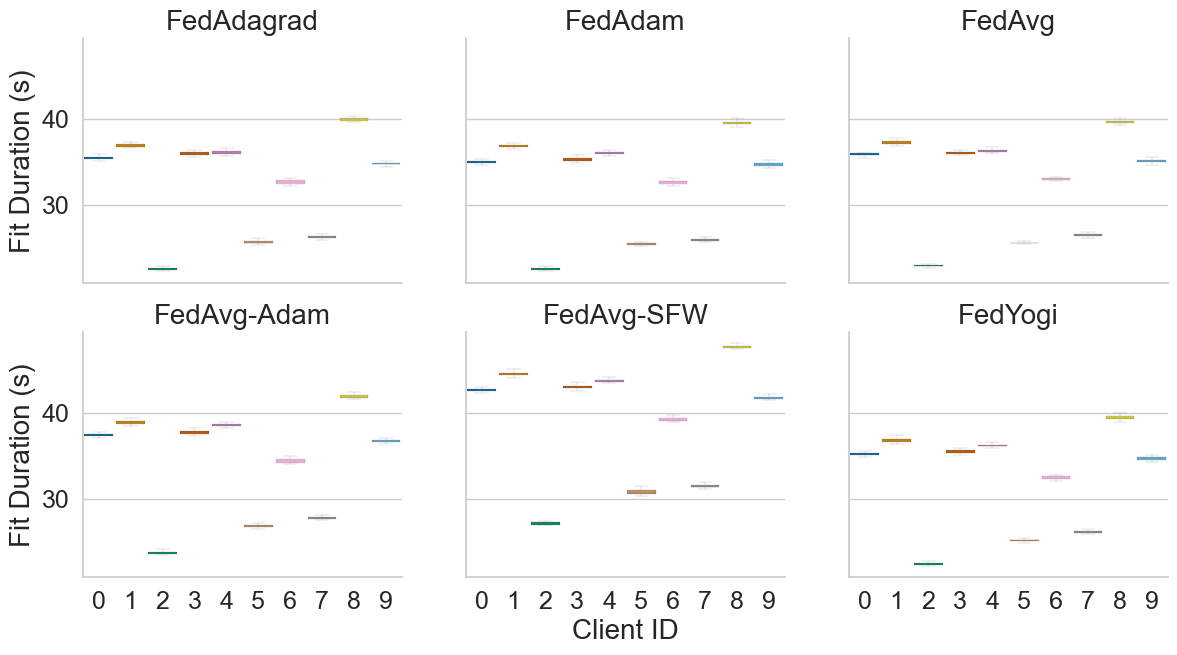

In [13]:
def plot_boxplot_sep(df, save_path, strategies_map, fontsize=fontsize):
    fig, axs = plt.subplots(2,3,figsize=(14,7),sharex=True,sharey=True)
    strategies = df['strategy'].unique()
    for i,strat in enumerate(strategies):
        myax = axs[i//3,i%3]
        df_s = df[df['strategy'] == strat]
        sns.boxplot(x='client id', y='mean', data=df_s, hue='client id',showfliers=False,linewidth=0.1, width=1, gap=0.1,ax=myax,palette='colorblind')
        myax.spines['top'].set_visible(False)
        myax.spines['right'].set_visible(False)
        myax.tick_params(axis='both', which='major', labelsize=fontsize-2)
        myax.set_title(strategies_map[strat],fontsize=fontsize)
        myax.set_xlabel('')
        myax.legend_.remove()
        if myax==axs[0,0] or myax==axs[1,0]:
            myax.set_ylabel('Fit Duration (s)',fontsize=fontsize)
        elif myax==axs[1,1]:
            myax.set_xlabel('Client ID',fontsize=fontsize)
        
    # ax.set_xlabel('Client ID', fontsize=fontsize)
    # ax.set_ylabel('Fit Duration (s)', fontsize=fontsize)
    #handles, labels = myax.get_legend_handles_labels()
    #labels = [strategies_map[key] for key in labels]
    #ax.legend(handles, labels, fontsize=fontsize-6, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncols=len(labels))
    #for x in range(0, 9):
    #    ax.axvline(x=x+0.5,color='grey',linestyle='--',dashes=(15,15),linewidth=0.2)
    #plt.savefig(save_path,format='pdf', dpi=300, bbox_inches='tight')
plot_boxplot_sep(fittimes5, os.path.join(graph_path,'fittimes5_boxplot.pdf'), strategies_map)
#plot_boxplot(fittimes1, os.path.join(graph_path,'fittimes1_boxplot.pdf'), strategies_map)

(None, None)

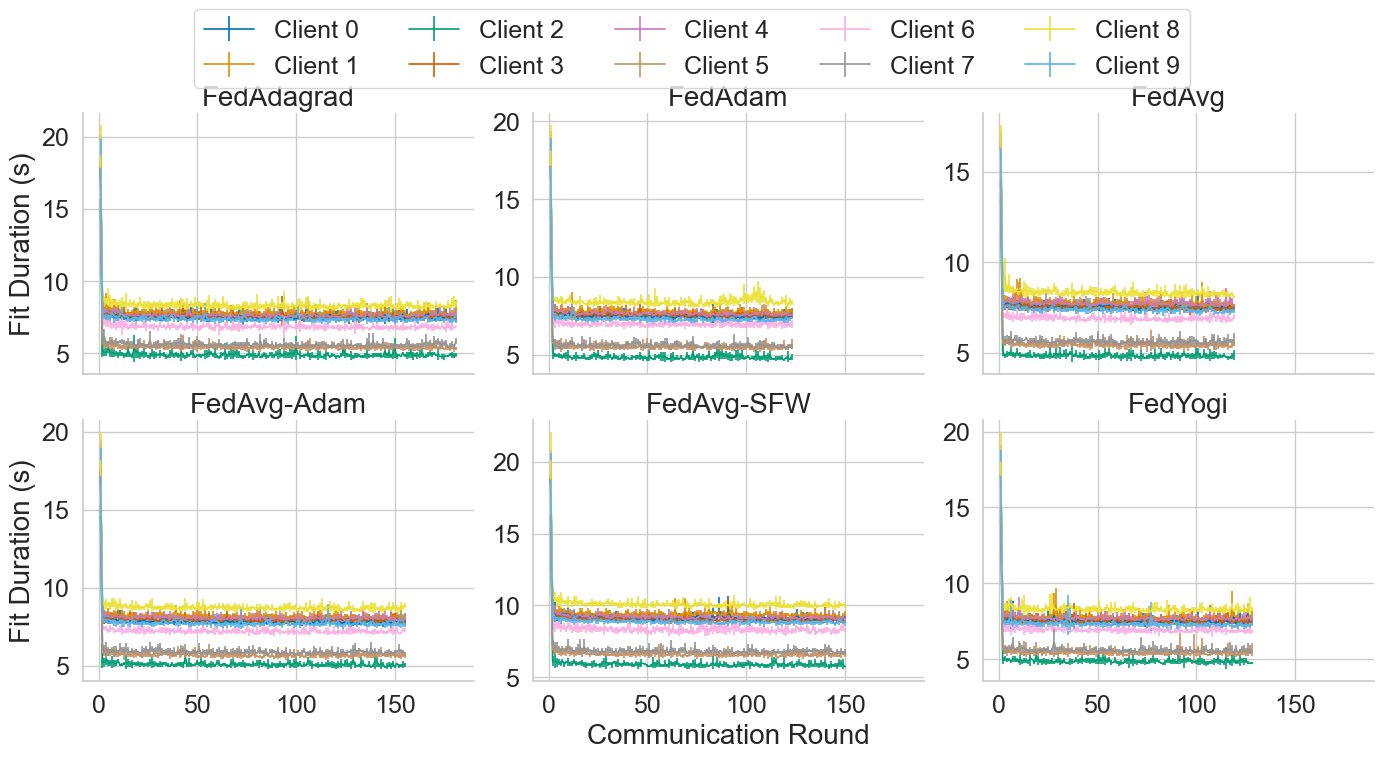

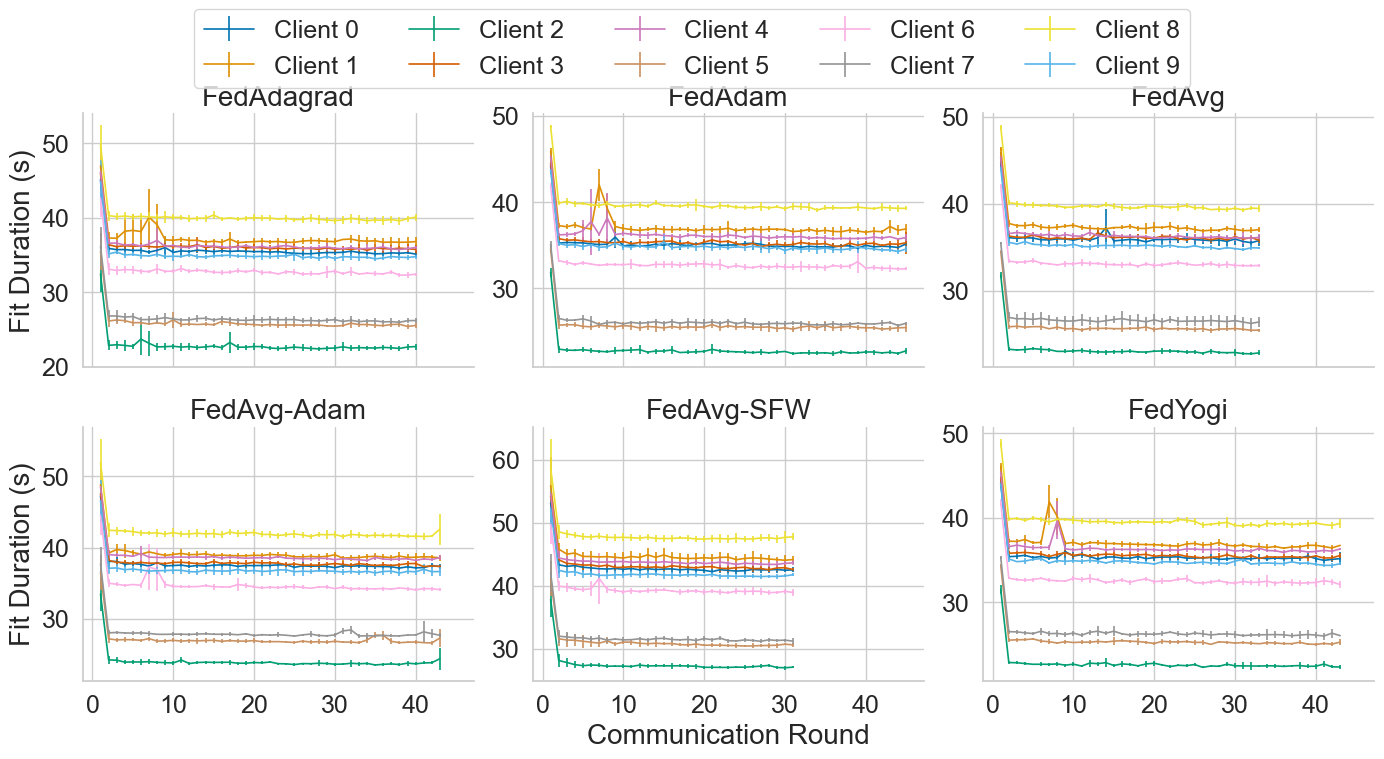

In [14]:

def plot_fittimes(fittimes, path_to_save=None):
    strategies = fittimes['strategy'].unique()
    fig, axs = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=False)
    lines_labels = []
    for i, strategy in enumerate(strategies):
        ax = axs[i // 3, i % 3]
        data = fittimes[fittimes['strategy'] == strategy]
        lines = []
        labels = []
        for client_id in data['client id'].unique():
            client_data = data[data['client id'] == client_id]
            #line, = ax.plot(client_data['server_round'], client_data['mean'], label=f'Client {client_id}', linewidth=2)
            line = ax.errorbar(client_data['server_round'], client_data['mean'], yerr=client_data['std'], label=f'Client {client_id}', linewidth=1.2, linestyle='-')
            lines.append(line)
            labels.append(f'Client {client_id}')

        ax.set_title(f'{strategies_map[strategy]}', fontsize=fontsize)
        ax.grid(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
        if ax==axs[0,0] or ax==axs[1,0]:
            ax.set_ylabel('Fit Duration (s)',fontsize=fontsize)
        elif ax==axs[1,1]:
            ax.set_xlabel('Communication Round',fontsize=fontsize)
        lines_labels.append((lines, labels))
        #ax.set_ylim(4, 100)

    # Create a common legend for all subplots at the upper center of the figure
    fig.legend(lines_labels[0][0], lines_labels[0][1], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5,fontsize=fontsize-2)
    if path_to_save is not None:
        plt.savefig(path_to_save, dpi=300, format='pdf', bbox_inches='tight')
    plt.tight_layout()
    #plt.show()
plot_fittimes(fittimes1, path_to_save=fittimes1_plot),plot_fittimes(fittimes5, path_to_save=fittimes5_plot)

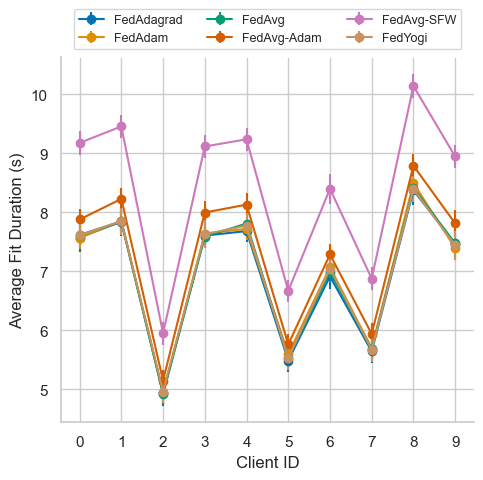

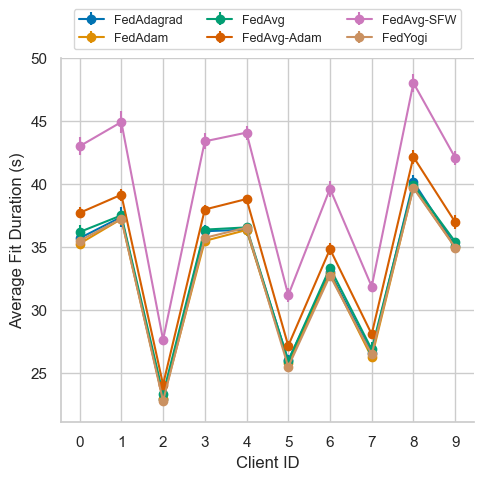

In [16]:

def get_client_wise_round_time(round_summary_gb):
    gb_keys = ['client id','strategy','epoch']
    by_client = round_summary_gb.groupby(gb_keys).agg(['sum','mean','count'])['fittime']
    #by_client['total_train_energy'] = by_client['mean']['sum']*1e3
    #by_client['mean_train_energy'] = by_client['mean']['mean']*1e3
    by_client['mean_round_time'] = by_client['mean']['mean']
    by_client['std_round_time'] = by_client['std']['mean']
    return by_client

def get_client_wise_strategy_round_time_plot(client_wise,epoch,metric='mean_round_time'):
    data1 = client_wise[(client_wise['epoch']==epoch)]
    strategies = data1['strategy'].unique()
    fig,axs = plt.subplots(1,1,figsize=(5,5))
    for strategy in strategies:
        subset1 = data1[data1['strategy']==strategy]
        #lines = axs.plot(subset1['client id'], subset1[metric], marker='o', label=strategies_map[strategy])
        lines = axs.errorbar(subset1['client id'], subset1[metric],yerr = subset1['std_round_time'], marker='o', label=strategies_map[strategy])
    axs.set_xticks(subset1['client id'])
    legend =plt.legend(bbox_to_anchor=(0.5, 1.15),
                       loc='upper center',
                       ncol=len(strategies)//2, 
                       fontsize=fontsize-11)
    #axs.set_ylabel(f'{metric} (s)')
    axs.grid(True)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.set_xlabel('Client ID')
    axs.set_ylabel('Average Fit Duration (s)')
    plt.tight_layout()
    plt.savefig(os.path.join(graph_path,f'avg_fitdur_{epoch}.pdf'),format='pdf',bbox_inches='tight')
    #plt.show()

client_wise_round_time = get_client_wise_round_time(round_summary_gb).reset_index()
client_wise_round_time
get_client_wise_strategy_round_time_plot(client_wise_round_time,'epoch_1','mean_round_time'),
get_client_wise_strategy_round_time_plot(client_wise_round_time,'epoch_5','mean_round_time')

#### 2. ROUND ENERGY ANALYSIS

In [27]:
rs_keys = ['strategy','epoch','client id','server_round']
fitenergy1 = round_summary_gb.xs('epoch_1', level='epoch')['round_energy_kWh']
fitenergy1['mean'] = fitenergy1['mean']*1e3
fitenergy1['std'] = fitenergy1['std']*1e3
fitenergy1 = fitenergy1.reset_index()

fitenergy5 = round_summary_gb.xs('epoch_5', level='epoch')['round_energy_kWh']
fitenergy5['mean'] = fitenergy5['mean']*1e3
fitenergy5['std'] = fitenergy5['std']*1e3
fitenergy5 = fitenergy5.reset_index()

In [104]:
round_summary_gb_flat = round_summary_gb.reset_index()
round_summary_gb_flat_1 = round_summary_gb_flat[round_summary_gb_flat['epoch']=='epoch_1']
round_summary_gb_flat_1
#sns.boxplot(x='client id', y='round_energy_kWh', hue='strategy', data=round_summary_gb_flat_1)

strategy    epoch client id server_round      lr             \
                                                     mean count  std   
0      fedadagrad  epoch_1         0            1  0.0316     5  0.0   
1      fedadagrad  epoch_1         0            2  0.0316     5  0.0   
2      fedadagrad  epoch_1         0            3  0.0316     5  0.0   
3      fedadagrad  epoch_1         0            4  0.0316     5  0.0   
4      fedadagrad  epoch_1         0            5  0.0316     5  0.0   
...           ...      ...       ...          ...     ...   ...  ...   
10475     fedyogi  epoch_1         9          124  0.0316     5  0.0   
10476     fedyogi  epoch_1         9          125  0.0316     5  0.0   
10477     fedyogi  epoch_1         9          126  0.0316     5  0.0   
10478     fedyogi  epoch_1         9          127  0.0316     5  0.0   
10479     fedyogi  epoch_1         9          128  0.0316     4  0.0   

         fittime                  ... ClientID_host round_energy_kWh        \
            mean count       std  ...           std             mean count   
0      17.803693     5  2.069962  ...           0.0         0.000064     5   
1       7.782156     5  0.435516  ...           0.0         0.000037     5   
2       7.733872     5  0.340014  ...           0.0         0.000038     5   
3       7.670427     5  0.285081  ...           0.0         0.000038     5   
4       7.882931     5  0.308586  ...           0.0         0.000040     5   
...          ...   ...       ...  ...           ...              ...   ...   
10475   7.167881     5  0.149017  ...           0.0         0.000035     5   
10476   7.277344     5  0.204231  ...           0.0         0.000036     5   
10477   7.230213     5  0.100037  ...           0.0         0.000038     5   
10478   7.194198     5  0.111552  ...           0.0         0.000036     5   
10479   7.362354     4  0.188232  ...           0.0         0.000035     4   

                    round_energy_J                   \
                std           mean count        std   
0      6.070619e-06     231.323619     5  21.854229   
1      2.478218e-06     133.823792     5   8.921586   
2      2.333709e-06     137.932166     5   8.401353   
3      2.907409e-06     137.266928     5  10.466671   
4      2.909088e-06     142.874308     5  10.472718   
...             ...            ...   ...        ...   
10475  6.861805e-07     126.873238     5   2.470250   
10476  1.333119e-06     130.373072     5   4.799229   
10477  2.408042e-06     135.848225     5   8.668952   
10478  2.935242e-07     127.981858     5   1.056687   
10479  5.832500e-07     127.385910     4   2.099700   

      round_energy_kWh_per_client                      
                             mean count           std  
0                        0.000064     5  6.070619e-06  
1                        0.000037     5  2.478218e-06  
2                        0.000038     5  2.333709e-06  
3                        0.000038     5  2.907409e-06  
4                        0.000040     5  2.909088e-06  
...                           ...   ...           ...  
10475                    0.000035     5  6.861805e-07  
10476                    0.000036     5  1.333119e-06  
10477                    0.000038     5  2.408042e-06  
10478                    0.000036     5  2.935242e-07  
10479                    0.000035     4  5.832500e-07  

[8560 rows x 37 columns]

In [28]:
fitenergy1

,strategy,client id,server_round,mean,count,std
0,fedadagrad,0,1,0.064257,5,0.006071
1,fedadagrad,0,2,0.037173,5,0.002478
2,fedadagrad,0,3,0.038314,5,0.002334
3,fedadagrad,0,4,0.038130,5,0.002907
4,fedadagrad,0,5,0.039687,5,0.002909
...,...,...,...,...,...,...
8555,fedyogi,9,124,0.035243,5,0.000686
8556,fedyogi,9,125,0.036215,5,0.001333
8557,fedyogi,9,126,0.037736,5,0.002408
8558,fedyogi,9,127,0.035551,5,0.000294


In [85]:
fitenergy1_plot = os.path.join(graph_path,"fitenergy1.pdf")
fitenergy5_plot = os.path.join(graph_path,"fitenergy5.pdf")

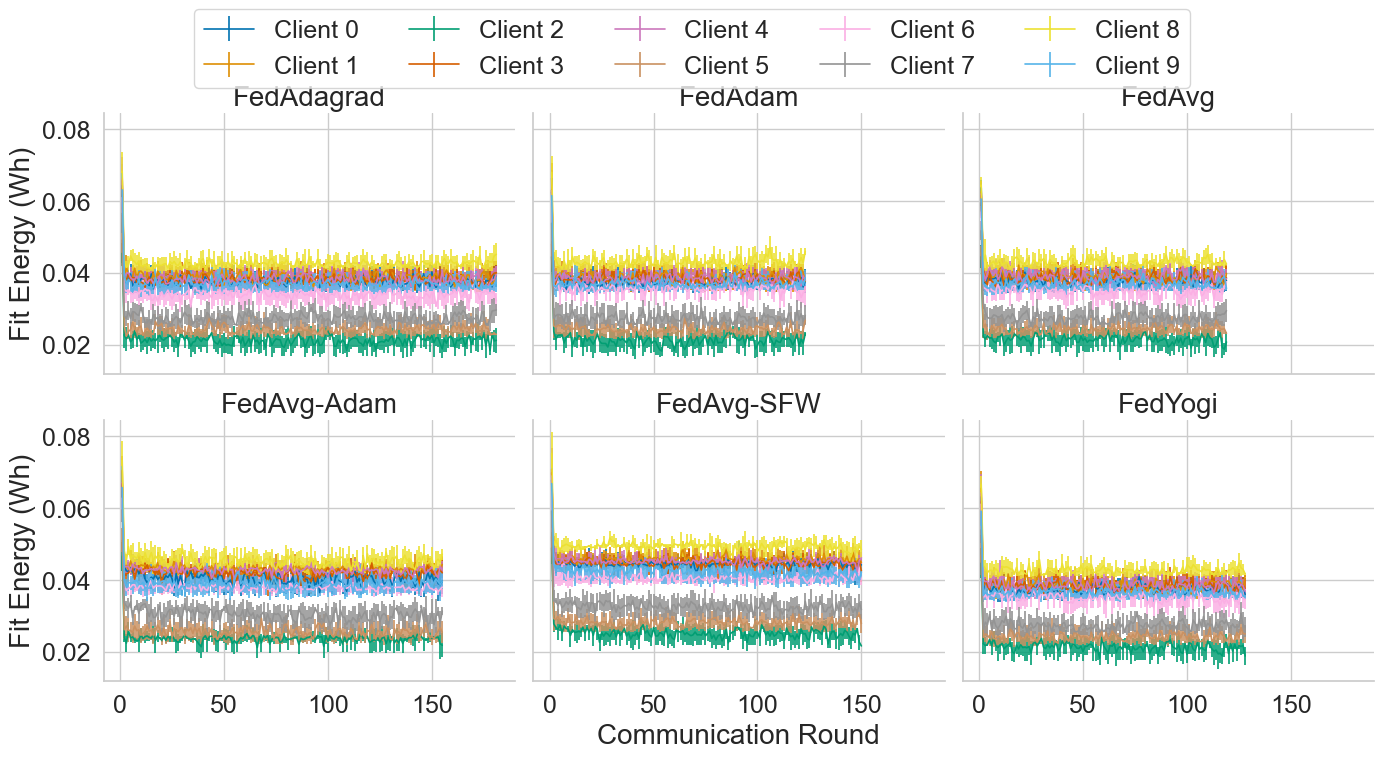

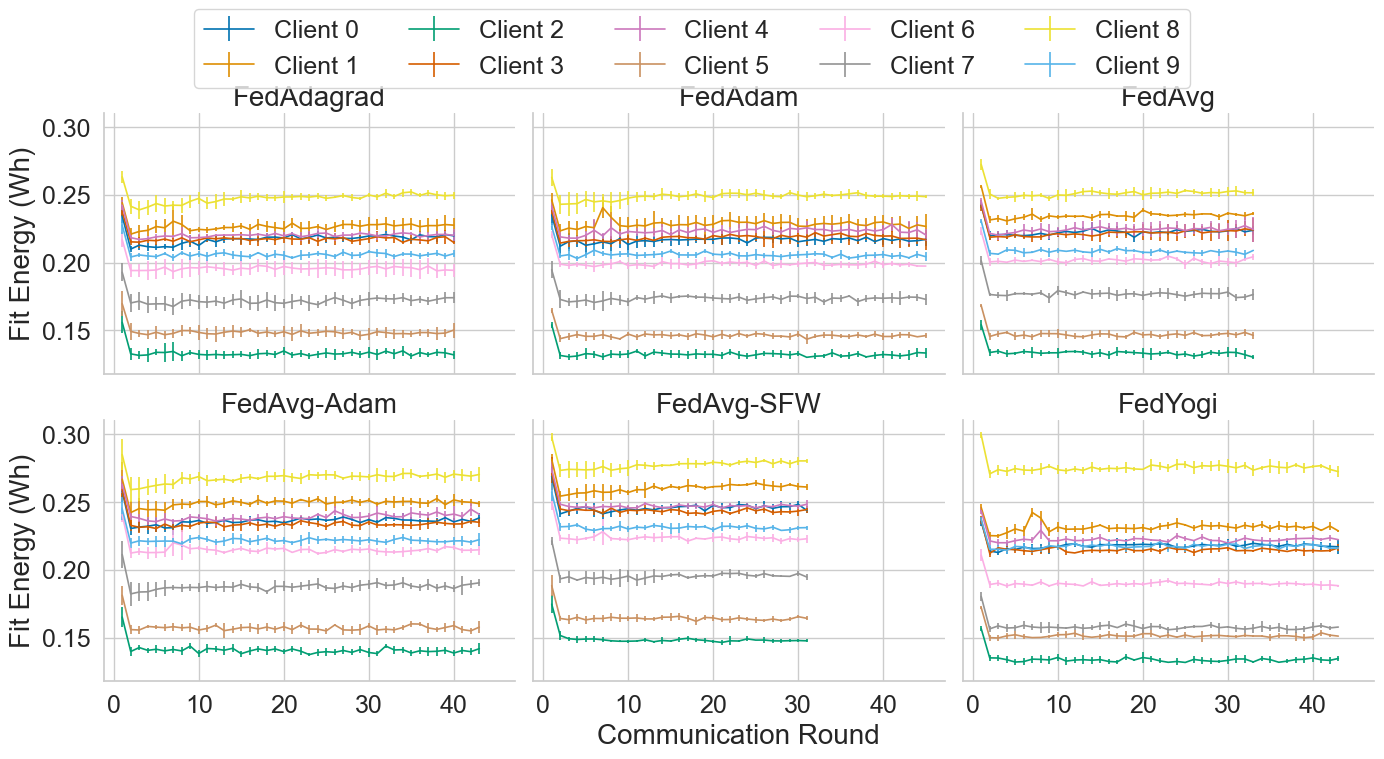

(None, None)

In [88]:
fitenergy1_plot = os.path.join(graph_path,"fitenergy1.pdf")
fitenergy5_plot = os.path.join(graph_path,"fitenergy5.pdf")
def plot_fitenergy(fitenergy, path_to_save=None):
    strategies = fitenergy['strategy'].unique()
    fig, axs = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=True)
    lines_labels = []
    for i, strategy in enumerate(strategies):
        ax = axs[i // 3, i % 3]
        data = fitenergy[fitenergy['strategy'] == strategy]
        lines = []
        labels = []
        for client_id in data['client id'].unique():
            client_data = data[data['client id'] == client_id]
            #line, = ax.plot(client_data['server_round'], client_data['mean'], label=f'Client {client_id}', linewidth=1)
            line = ax.errorbar(client_data['server_round'], client_data['mean'], yerr=client_data['std'], label=f'Client {client_id}', linewidth=1.2)
            lines.append(line)
            labels.append(f'Client {client_id}')
        ax.set_title(f'{strategies_map[strategy]}',fontsize=fontsize)
        ax.grid(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
        if ax==axs[0,0] or ax==axs[1,0]:
            ax.set_ylabel('Fit Energy (Wh)', fontsize=fontsize)
        elif ax==axs[1,1]:
            ax.set_xlabel('Communication Round', fontsize=fontsize)
        lines_labels.append((lines, labels))

    # Create a common legend for all subplots at the upper center of the figure
    fig.legend(lines_labels[0][0], lines_labels[0][1], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5,fontsize=fontsize-2)
    if path_to_save is not None:
        plt.savefig(path_to_save, dpi=300, format='pdf',bbox_inches='tight')
    plt.tight_layout()
    plt.show()
plot_fitenergy(fitenergy1, path_to_save=fitenergy1_plot),plot_fitenergy(fitenergy5, path_to_save=fitenergy5_plot)

In [11]:
# TOTAL TRAIN ENERGY STRATEGY AND EPOCH
gb_keys = ['strategy','epoch']
by_strategy = round_summary_gb.groupby(gb_keys).agg(['sum','mean','count'])['round_energy_kWh_per_client']
by_strategy['total_train_energy'] = by_strategy['mean']['sum']*1e3
by_strategy['mean_train_energy'] = by_strategy['mean']['mean']*1e3
by_strategy['rounds'] = by_strategy['mean']['count']/10
by_strategy
by_strategy[['total_train_energy','mean_train_energy','rounds']]

total_train_energy mean_train_energy rounds
                                                                  
strategy       epoch                                              
fedadagrad     epoch_1          61.692559          0.034084  181.0
               epoch_5          79.512184          0.198780   40.0
fedadam        epoch_1          42.269037          0.034365  123.0
               epoch_5          89.846462          0.199659   45.0
fedavg         epoch_1          41.050186          0.034496  119.0
               epoch_5          66.898054          0.202721   33.0
fedavg_adam    epoch_1          57.618624          0.037173  155.0
               epoch_5          92.522966          0.215170   43.0
fedconstraints epoch_1          60.000329          0.040000  150.0
               epoch_5          69.537819          0.224316   31.0
fedyogi        epoch_1          43.809365          0.034226  128.0
               epoch_5          86.644511          0.201499   43.0

In [12]:
print(by_strategy[['total_train_energy','mean_train_energy','rounds']].to_latex(
    float_format="{:0.2f}".format,
))

\begin{tabular}{llrrr}
\toprule
 &  & total_train_energy & mean_train_energy & rounds \\
 &  &  &  &  \\
strategy & epoch &  &  &  \\
\midrule
\multirow[t]{2}{*}{fedadagrad} & epoch_1 & 61.69 & 0.03 & 181.00 \\
 & epoch_5 & 79.51 & 0.20 & 40.00 \\
\cline{1-5}
\multirow[t]{2}{*}{fedadam} & epoch_1 & 42.27 & 0.03 & 123.00 \\
 & epoch_5 & 89.85 & 0.20 & 45.00 \\
\cline{1-5}
\multirow[t]{2}{*}{fedavg} & epoch_1 & 41.05 & 0.03 & 119.00 \\
 & epoch_5 & 66.90 & 0.20 & 33.00 \\
\cline{1-5}
\multirow[t]{2}{*}{fedavg_adam} & epoch_1 & 57.62 & 0.04 & 155.00 \\
 & epoch_5 & 92.52 & 0.22 & 43.00 \\
\cline{1-5}
\multirow[t]{2}{*}{fedconstraints} & epoch_1 & 60.00 & 0.04 & 150.00 \\
 & epoch_5 & 69.54 & 0.22 & 31.00 \\
\cline{1-5}
\multirow[t]{2}{*}{fedyogi} & epoch_1 & 43.81 & 0.03 & 128.00 \\
 & epoch_5 & 86.64 & 0.20 & 43.00 \\
\cline{1-5}
\bottomrule
\end{tabular}



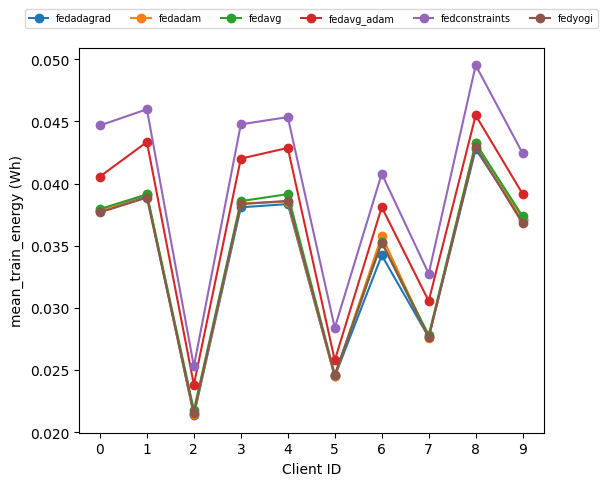

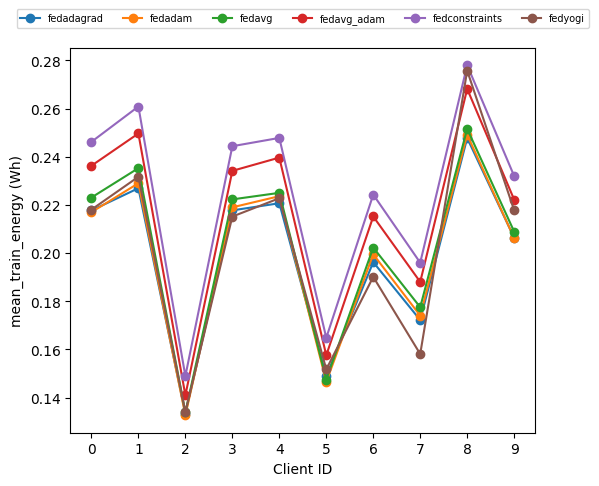

(None, None)

In [168]:
def get_client_wise_energy(round_summary_gb):
    gb_keys = ['client id','strategy','epoch']
    by_client = round_summary_gb.groupby(gb_keys).agg(['sum','mean','count'])['round_energy_kWh_per_client']
    by_client['total_train_energy'] = by_client['mean']['sum']*1e3
    by_client['mean_train_energy'] = by_client['mean']['mean']*1e3
    return by_client

def get_client_wise_strategy_plot(client_wise,epoch,metric='total_train_energy'):
    data1 = client_wise[(client_wise['epoch']==epoch)]
    strategies = data1['strategy'].unique()
    fig,axs = plt.subplots(1,1,figsize=(6,5))
    for strategy in strategies:
        subset1 = data1[data1['strategy']==strategy]
        axs.plot(subset1['client id'], subset1[metric], marker='o', label=strategy)
    axs.set_xticks(subset1['client id'])
    legend =plt.legend(bbox_to_anchor=(0.5, 1.10),
                       loc='upper center',
                       ncol=len(strategies), 
                       borderaxespad=0.,
                       fontsize=7)
    axs.set_ylabel(f'{metric} (Wh)')
    axs.set_xlabel('Client ID')
    plt.show()
client_wise = get_client_wise_energy(round_summary_gb).reset_index()
metric = 'mean_train_energy'
get_client_wise_strategy_plot(client_wise, 
                              'epoch_1',
                              metric=metric), \
get_client_wise_strategy_plot(client_wise, 'epoch_5',metric)

In [23]:
gb_key = ['client id','epoch','strategy']
by_fittime = round_summary_gb.groupby(gb_key).agg(['mean','count'])['fittime']

### DATA PARTITIONNED 

<Axes: xlabel='client id', ylabel='data_size'>

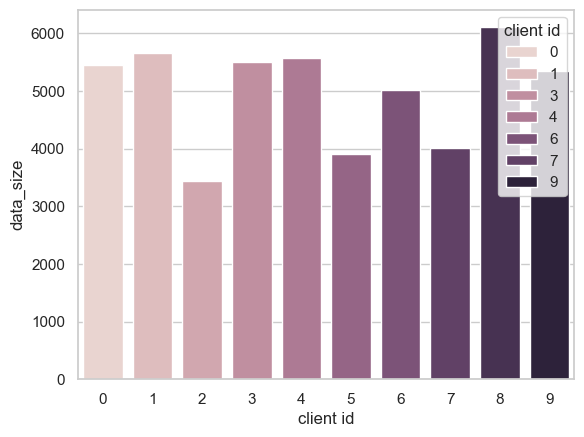

In [17]:
path_idx_data = "/Users/Slaton/Documents/grenoble-code/fl-flower/energyfl/outputcifar10/10clients/idx_map.json"
import json 
import numpy as np
with open(path_idx_data,'r') as f:
    idx_map = json.load(f)
idx_map.keys()
data_size = [len(idx_map[k]) for k in idx_map.keys()]
client_size_df = pd.DataFrame({'client id':np.arange(len(idx_map.keys())),'data_size':data_size})
sns.barplot(data=client_size_df, x='client id', y='data_size',hue='client id', dodge=False)